# Introduction to Bayesian Learning
Author: Volker Krueger

## Numbers Dataset

We have a dataset of handwritten digits from 0 to 9

In [4]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from PIL import Image



samples_per_class = 500
number_of_classes = 10

filelist = sorted(glob.glob('../../data/mnist-data/*/*.png'))
x = np.array([np.array(Image.open(fname)) for fname in filelist])

y = np.zeros(number_of_classes * samples_per_class,dtype=int)
for cls in range(1,number_of_classes):
    y[(cls*500):(cls+1)*500] = cls   



## Visualizing the Dataset

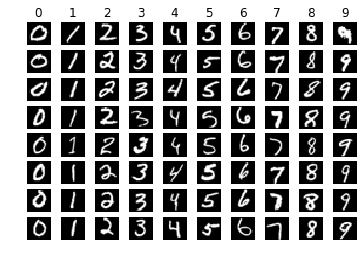

In [5]:
examples_per_class = 8
for cls in range(number_of_classes):
    idxs = np.where(y == cls)[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, number_of_classes, i * number_of_classes + cls + 1)
        plt.imshow(x[idx].astype('uint8'), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(str(cls))
plt.show()

## Mean

compute the mean of each class and display

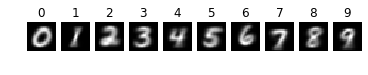

In [6]:
mean_of_class=np.zeros((10,20,20))
for cls in range(number_of_classes):
    idxs = np.where(y == cls)[0]
    mean_of_class[cls]=np.mean(x[idxs],axis=0)
    plt.subplot(1, number_of_classes, cls + 1)
    plt.imshow(mean_of_class[cls].astype('uint8'), cmap='gray')
    plt.axis('off')
    plt.title(str(cls))
plt.show()


## Generate Training and Testing data, and visualize

In [7]:
#######################################################################
# x_train will contain the training data
# y_train will contain the correct classes of the training data
# x_test will contain the test data
# y_test will contain the correct classes for the test data
#######################################################################
x_train=np.zeros((4000,20,20))
y_train=np.zeros(4000)
x_test =np.zeros((1000,20,20))
y_test =np.zeros(1000)

for cls in range(number_of_classes):
    idx=cls*400
    idx1=cls*500
    idx2=cls*100
    x_train[idx:idx+400,:,:]=x[idx1:idx1+400,:,:]
    y_train[idx:idx+400]=y[idx1:idx1+400]
    x_test[idx2:idx2+100,:,:]=x[idx1+400:idx1+500,:,:]
    y_test[idx2:idx2+100]=y[idx1+400:idx1+500]

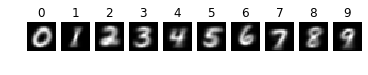

In [36]:
mean_of_class=np.zeros((10,20,20))
for cls in range(number_of_classes):
    idxs = np.where(y_train == cls)[0]
    mean_of_class[cls]=np.mean(x_train[idxs],axis=0)
    plt.subplot(1, number_of_classes, cls + 1)
    plt.imshow(mean_of_class[cls].astype('uint8'), cmap='gray')
    plt.axis('off')
    plt.title(str(cls))
plt.show()

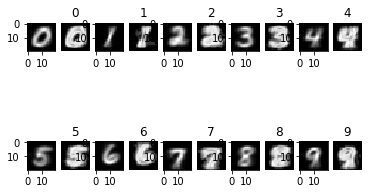

In [41]:
mean_of_class=np.zeros((10,20,20))
stdev_of_class=np.zeros((10,20,20))
for cls in range(number_of_classes):
    #print(x_test[idxs])
    idxs = np.where(y_test == cls)[0]
    mean_of_class[cls] = np.mean(x_test[idxs], axis=0)
    stdev_of_class[cls] = np.std(x_test[idxs], axis=0)
    plt.subplot(2, number_of_classes, cls*2 + 1)
    plt.imshow(mean_of_class[cls].astype('uint8'), cmap='gray')
    plt.subplot(2, number_of_classes, cls*2 + 1 + 1)
    plt.imshow(stdev_of_class[cls].astype('uint8'), cmap='gray')
    plt.axis('off')
    plt.title(str(cls))
plt.show()

# Implementing NCC and NB

## Nearest Centroid

In [115]:
class NearestCentroid:
    
    #def __init__(self):
        
    def fit(self, x_train, y_train, amount_of_classes):
        y_train = [int(i) for i in y_train]
        sample_counter = np.zeros(amount_of_classes)
        self.centroids = np.zeros((10, len(x_train[0])))
        for i in range(len(y_train)):
            sample_counter[y_train[i]] += 1
            self.centroids[y_train[i]] = [sum(x) for x in zip(self.centroids[y_train[i]], x_train[i])]
              
        for i in range(amount_of_classes):
            self.centroids[i] = [c/sample_counter[i] for c in self.centroids[i]]
        
        
    def print_centroids(self, ran):
        [print(self.centroids[i]) for i in range(ran)]
        
        
    def predict(self, samples):
        return [np.argmin([np.linalg.norm(sample - centroid) for centroid in self.centroids]) for sample in samples]
    
n_c_model = NearestCentroid()
n_c_model.fit([x_train[i].flatten() for i in range(len(y_train))], y_train, 10)   

In [272]:
from scipy.stats import norm as normal
from scipy.stats import multivariate_normal as mvn
    
class NaiveBayes:
    def fit(self, x_train, y_train, amount_of_classes):
        self.number_of_classes = amount_of_classes
        self.mean_of_class = np.zeros((10, 400))
        self.stdev_of_class = np.zeros((10, 400))
        
        for cls in range(number_of_classes):
            idxs = np.where(y_train == cls)[0]
            #print(idxs)
            self.mean_of_class[cls] = np.mean(x_train[idxs], axis=0).flatten()
            self.stdev_of_class[cls] = np.std(x_train[idxs], axis=0).flatten()
            #print(self.stdev_of_class[cls])
            #self.stdev_of_class[cls] = np.maximum(self.stdev_of_class[cls], 0.1)
            self.stdev_of_class[cls] = self.stdev_of_class[cls] + 5
            #print(self.stdev_of_class[cls])
            
    def predict_one(self, sample):
        return np.argmax([
                    np.sum(normal.logpdf(sample.flatten(), loc=self.mean_of_class[cls], scale=self.stdev_of_class[cls])) 
                    for cls in range(self.number_of_classes)
                ])
            
    def predict(self, samples):
        #print(type(samples))
        #print(samples.shape)
        #print(samples[0])
        return [self.predict_one(sample) for sample in samples]
     
n_b_model = NaiveBayes()
n_b_model.fit(x_train, y_train, 10)    
#print(len(n_b_model.pdfs))
#print(n_b_model.pdfs)
#print(sum(n_b_model.mean_of_class))
#print(n_b_model.stdev_of_class[0])
#for i in range(0, 4000, 100):
#    print(n_b_model.predict([x_train[i]]))

# Comparing performance with sklearn

## Naive Bayesian classifier from sklearn

In [267]:
from sklearn.naive_bayes import MultinomialNB
bayes_sk = MultinomialNB(alpha=0.0001)
bayes_sk.fit([x_train[i].flatten() for i in range(4000)], y_train.flatten())

MultinomialNB(alpha=0.0001, class_prior=None, fit_prior=True)

## Nearest Centroid classifier from sklearn


In [268]:
from sklearn.neighbors import NearestCentroid
n_c_sk = NearestCentroid()
n_c_sk.fit([x_train[i].flatten() for i in range(4000)], y_train)

NearestCentroid(metric='euclidean', shrink_threshold=None)

## Testing Nearest Centroid

In [269]:
#input: x_test
#output: y_test_pred
def model_test (model, x_test):
    y_test_pred = model.predict([x_test[i].flatten() for i in range(len(x_test))])
    return y_test_pred

def model_test_no_flat (model, x_test):
    y_test_pred = model.predict(x_test)
    return y_test_pred

In [270]:
y_test_pred = model_test_no_flat(n_b_model, x_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Naive bayes acc: ', test_accuracy)

y_test_pred = model_test(n_c_model, x_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Nearest centroid acc: ', test_accuracy)

Naive bayes acc:  0.741
Nearest centroid acc:  0.796


### Comparing accuracy between sklearns Naive Bayes and sklearns Nearest Centroid

In [271]:
# Evaluate your classifier on the test set
y_test_pred = model_test(bayes_sk, x_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Naive bayes acc: ', test_accuracy)
y_test_pred = model_test(n_c_sk, x_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Nearest Centroid acc: ', test_accuracy)

Naive bayes acc:  0.81
Nearest Centroid acc:  0.796


## Let's visualize some of the wrongly classified test samples.

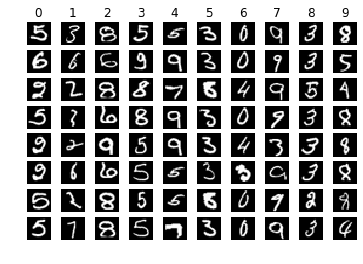

In [17]:
examples_per_class = 8
for cls in range(number_of_classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=True)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, number_of_classes, i * number_of_classes + cls + 1)
        plt.imshow(x_test[idx].astype('uint8'), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(str(cls))
plt.show()

## Let's visualize some of the correctly classified test samples.

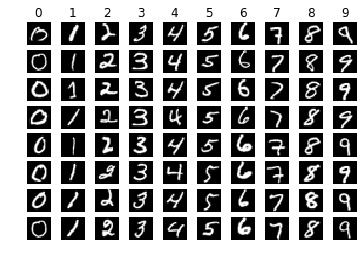

In [18]:
examples_per_class = 8
for cls in range(number_of_classes):
    idxs = np.where((y_test == cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=True)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, number_of_classes, i * number_of_classes + cls + 1)
        plt.imshow(x_test[idx].astype('uint8'), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(str(cls))
plt.show()